In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
InputDir='/scratch/TESTS/Aim2/Inputs'
OutputDir='/scratch/TESTS/Aim2/Outputs'
MatlabFilesDir='/scratch/TESTS/Aim2/MatlabFiles'

label_fn = os.path.join(InputDir,'fswm_extended_neuro2012_20_merge_seg.nii.gz')
t1_fn = os.path.join(InputDir,'t1_average_BRAINSABC.nii.gz')
t2_fn = os.path.join(InputDir,'t2_average_BRAINSABC.nii.gz')
dwi_fn = os.path.join(InputDir,'DWI_Corrected_Aligned_CS.nrrd')
#dwi_fn = os.path.join(InputDir,'CorrectedDWI_in_T2Space.nrrd')

In [3]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
#PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release_20150715/bin'
PROGRAM_PATHS = '/scratch/BS/release-20150706/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from nipype.interfaces.ants import DenoiseImage
from SEMTools import *

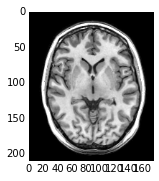

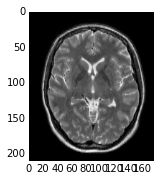

In [4]:
t1 = sitk.ReadImage(t1_fn)
t2 = sitk.ReadImage(t2_fn)

myshow(t1)
myshow(t2)

In [5]:
def ExtractBRAINFromHead(headImage, labelsMap):
    label_mask = labelsMap>0
    brainImage = sitk.Cast(headImage,sitk.sitkInt16) * sitk.Cast(label_mask,sitk.sitkInt16)
    return brainImage

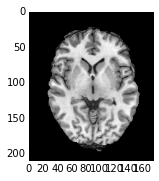

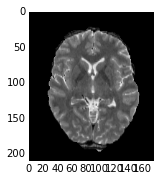

In [6]:
labelMap = sitk.ReadImage(label_fn)
t1 = ExtractBRAINFromHead(t1,labelMap)
t2 = ExtractBRAINFromHead(t2,labelMap)
myshow(t1)
myshow(t2)

In [7]:
# Now we read dwi image and extract its b0
myExtracter = extractNrrdVectorIndex()
myExtracter.inputs.inputVolume = dwi_fn
myExtracter.inputs.vectorIndex = 0
myExtracter.inputs.outputVolume = os.path.join(OutputDir,'dwi_b0.nrrd')
print(myExtracter.cmdline)
myExtracter.run()

INFO:interface:stdout 2016-02-04T10:05:30.675008:Input Image: /scratch/TESTS/Aim2/Inputs/DWI_Corrected_Aligned_CS.nrrd
INFO:interface:stdout 2016-02-04T10:05:30.675008:Output Image: /scratch/TESTS/Aim2/Outputs/dwi_b0.nrrd
INFO:interface:stdout 2016-02-04T10:05:30.675008:Vector Index: 0
INFO:interface:stdout 2016-02-04T10:05:30.675008:Set Image Orientation: AsAcquired
INFO:interface:stdout 2016-02-04T10:05:30.675008:


 extractNrrdVectorIndex  --inputVolume /scratch/TESTS/Aim2/Inputs/DWI_Corrected_Aligned_CS.nrrd --outputVolume /scratch/TESTS/Aim2/Outputs/dwi_b0.nrrd --vectorIndex 0


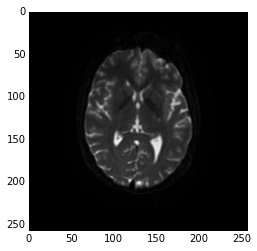

In [8]:
dwi_b0 = sitk.ReadImage(myExtracter.inputs.outputVolume)
myshow(dwi_b0)

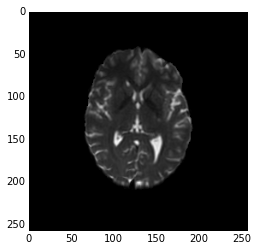

In [9]:
# Now resample the brain mask to normalized space to remove DWI skull
resampler2 = sitk.ResampleImageFilter()
resampler2.SetReferenceImage(dwi_b0)
resampler2.SetInterpolator(sitk.sitkNearestNeighbor)
labelMap = resampler2.Execute(labelMap)

dwi_b0 = ExtractBRAINFromHead(dwi_b0,labelMap)
myshow(dwi_b0)

In [10]:
# Now t1 and t2 have original t1, t2 voxel lattice with following specifications:
print(t1.GetSize())
print(t2.GetSize())
print(t1.GetDirection())
print(t2.GetDirection())
print(t1.GetOrigin())
print(t2.GetOrigin())

(174, 208, 186)
(174, 208, 186)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(-88.5, -88.5, -89.5)
(-88.5, -88.5, -89.5)


In [11]:
print(dwi_b0.GetSize())
print(dwi_b0.GetDirection())
print(dwi_b0.GetOrigin())

(256, 256, 61)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)


In [12]:
############################
# Now JUST FOR MATLAB TEST:
############################
# resample t1 and t2 to DWI space (256x256x61)
#
resampler1 = sitk.ResampleImageFilter()
resampler1.SetReferenceImage(dwi_b0)
t1 = resampler1.Execute(t1)
t2 = resampler1.Execute(t2)

print(t1.GetSize())
print(t2.GetSize())
print(t1.GetDirection())
print(t2.GetDirection())
print(t1.GetOrigin())
print(t2.GetOrigin())

(256, 256, 61)
(256, 256, 61)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)


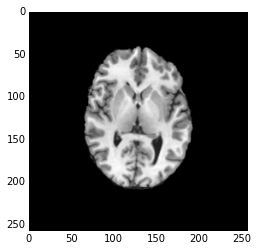

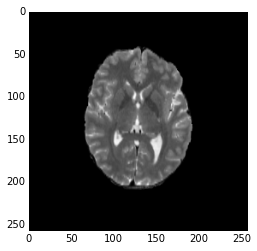

In [13]:
myshow(t1)
myshow(t2)

In [14]:
# Now set direction cosign of all images to identity
def ForceDCtoID(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    return inputVolume

def ForceOriginToZero(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetOrigin((0.0, 0.0, 0.0))
    return inputVolume

In [15]:
dwi_b0 = ForceDCtoID(dwi_b0)
dwi_b0 = ForceOriginToZero(dwi_b0)

t1 = ForceDCtoID(t1)
t1 = ForceOriginToZero(t1)

t2 = ForceDCtoID(t2)
t2 = ForceOriginToZero(t2)

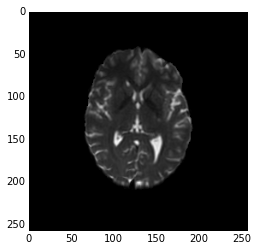

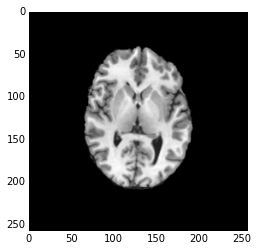

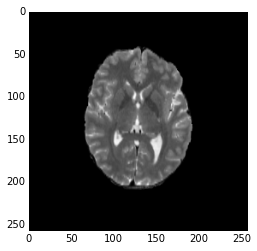

In [16]:
myshow(dwi_b0)
myshow(t1)
myshow(t2)

In [17]:
print(t1.GetSize())
print(t1.GetDirection())
print(t1.GetOrigin())

print(t2.GetSize())
print(t2.GetDirection())
print(t2.GetOrigin())

print(dwi_b0.GetSize())
print(dwi_b0.GetDirection())
print(dwi_b0.GetOrigin())

(256, 256, 61)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.0)
(256, 256, 61)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.0)
(256, 256, 61)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.0)


In [18]:
def NormalizeBetweenZeroAndOne(image):
    image_double = sitk.Cast(image, sitk.sitkFloat32)
    # new range
    newMax=1.0
    newMin=0
    # Find old range
    totalStats = sitk.StatisticsImageFilter()
    totalStats.Execute(image_double)
    oldMax=totalStats.GetMaximum()
    oldMin=totalStats.GetMinimum()
    f=(newMax-newMin)/(oldMax-oldMin)
    Normalized_image = (image_double-oldMin)*f+newMin
    return Normalized_image

In [19]:
# Save the axial 2d dwi file (dwib0_2D) as a matlab file in "MatlabFiles" directory.

dwib0_2D = dwi_b0[:,:,dwi_b0.GetSize()[2]/2]

print(dwib0_2D.GetSize())
print(dwib0_2D.GetSpacing())

# Now normalize dwi_b0 to have values between 0 and 1
dwib0_2D = NormalizeBetweenZeroAndOne(dwib0_2D)
dwi_im_arr = sitk.GetArrayFromImage(dwib0_2D)

import scipy.io
scipy.io.savemat(os.path.join(MatlabFilesDir,'dwib0_testdata.mat'), mdict={'inputImage': dwi_im_arr})

(256, 256)
(1.0, 1.0000000000000004)


In [22]:
###### JUST FOR EXPERIMENT ########################
#t1d = t1*4 + 500
#t2d = t2/4 - 100
t1d = t1
t2d = t2

In [23]:
# Write images to the disk for checking their alignment in slicer
sitk.WriteImage(t1d,os.path.join(OutputDir,'t1_inVoxelSpace.nii.gz'))
sitk.WriteImage(t2d,os.path.join(OutputDir,'t2_inVoxelSpace.nii.gz'))
sitk.WriteImage(dwi_b0,os.path.join(OutputDir,'dwi_b0_inVoxelSpace.nii.gz'))

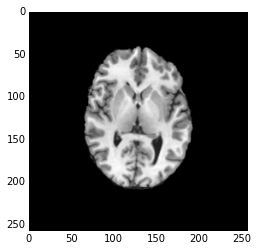

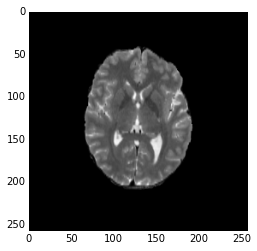

In [24]:
myshow(t1d)
myshow(t2d)

In [25]:
t1g = sitk.GradientMagnitude(t1d)
t2g = sitk.GradientMagnitude(t2d)

totalStats = sitk.StatisticsImageFilter()

totalStats.Execute(t1d)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

totalStats.Execute(t1g)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

totalStats.Execute(t2d)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

totalStats.Execute(t2g)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())


4046.0
0.0
2559.32861328
0.0
4096.0
0.0
2786.74291992
0.0


In [26]:
################################################################
# Now we find the gradient magnitude edge map from T1 and T2
# Such that we rescale the intensities of both image and pick the maximum value at each pixel
################################################################

MGI = GenerateSummedGradientImage() # Maximum Gradient Image
MGI.inputs.inputVolume1 = os.path.join(OutputDir,'t1_inVoxelSpace.nii.gz')
MGI.inputs.inputVolume2 = os.path.join(OutputDir,'t2_inVoxelSpace.nii.gz')
MGI.inputs.MaximumGradient = True
MGI.inputs.outputFileName = os.path.join(OutputDir,'MaximumGradientImage.nii.gz')
print(MGI.cmdline)
MGI.run()

INFO:interface:stdout 2016-02-04T10:09:33.707466:Quntile 50: 1.47278
INFO:interface:stdout 2016-02-04T10:09:33.707466:Quntile 65: 1.91461
INFO:interface:stdout 2016-02-04T10:09:33.707466:Quntile 75: 2.20916
INFO:interface:stdout 2016-02-04T10:09:33.707466:Quntile 85: 13.6262
INFO:interface:stdout 2016-02-04T10:09:33.707466:Quntile 86: 48.9242
INFO:interface:stdout 2016-02-04T10:09:33.707466:Quntile 87: 79.8297
INFO:interface:stdout 2016-02-04T10:09:33.707466:Quntile 88: 118.411
INFO:interface:stdout 2016-02-04T10:09:33.707466:Quntile 89: 160.89
INFO:interface:stdout 2016-02-04T10:09:33.714352:Quntile 90: 202.483
INFO:interface:stdout 2016-02-04T10:09:33.714352:Quntile 95: 412.155
INFO:interface:stdout 2016-02-04T10:09:33.714352:Quntile 100: 2559.58
INFO:interface:stdout 2016-02-04T10:09:33.724094:Writing output ... 


 GenerateSummedGradientImage  --MaximumGradient  --inputVolume1 /scratch/TESTS/Aim2/Outputs/t1_inVoxelSpace.nii.gz --inputVolume2 /scratch/TESTS/Aim2/Outputs/t2_inVoxelSpace.nii.gz --outputFileName /scratch/TESTS/Aim2/Outputs/MaximumGradientImage.nii.gz


28.0
1.0


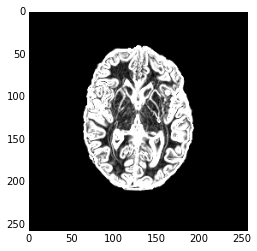

In [27]:
#
#
#
#
#
#
# Start from here for further operation on maximumGradientImage
################################################################
mgi = sitk.ReadImage(MGI.inputs.outputFileName)
myshow(mgi)

totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(mgi)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

In [28]:
#mgi = NormalizeBetweenZeroAndOne(mgi)
#myshow(mgi)

In [29]:
'''
label = mgi>0
#myshow(label)

labelStats = sitk.LabelStatisticsImageFilter()
labelStats.Execute(mgi,label)
print(labelStats.GetMaximum(1))
print(labelStats.GetMinimum(1))
print(labelStats.GetMean(1))

# epsilon is set as the minimum value through the mask region
#epsilon = labelStats.GetMinimum(1)
'''
#epsilon = 1
epsilon = 0
print('epsilon: {0}'.format(epsilon))

mgi = sitk.Cast(mgi,sitk.sitkFloat32) + epsilon
totalStats.Execute(mgi)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

epsilon: 0
28.0
1.0


1.0
0.0357142873108


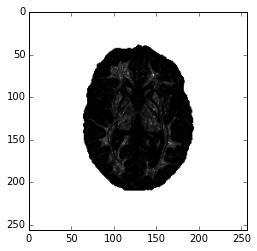

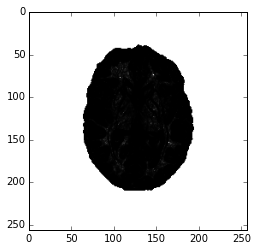

In [34]:
# "edgeMask" is computed as 1/mgi or 1/(mgi)^2
#----------------------------------------------
# compute 1/mgi
div = sitk.DivideImageFilter()
edgeMask1 = div.Execute(1.0,mgi)
myshow(edgeMask1)

# compute 1/(mgi)^2
mgi2 = sitk.Square(mgi)
div = sitk.DivideImageFilter()
edgeMask2 = div.Execute(1.0,mgi2)
myshow(edgeMask2)
#----------------------------------------------

edgeMask = edgeMask1
#edgeMask = edgeMask2

totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(edgeMask)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

In [36]:
#edgeMask = NormalizeBetweenZeroAndOne(edgeMask)
#myshow(edgeMask)

#edgeMask = sitk.Square(edgeMask)

totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(edgeMask)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

1.0
0.00127551029436


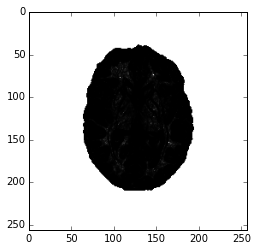

In [37]:
edgeMask_2D = edgeMask[:,:,edgeMask.GetSize()[2]/2]
myshow(edgeMask_2D)

edge_arr = sitk.GetArrayFromImage(edgeMask_2D)

import scipy.io
scipy.io.savemat(os.path.join(MatlabFilesDir,'edgemask_t1t2_1ByGMI_square.mat'), mdict={'edgemask': edge_arr})